In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = 'data/'

In [10]:
products = pd.read_csv(f'{PATH}amazon_baby_subset.csv',low_memory=False)

In [11]:
products = products.fillna({'review':''})

In [12]:
def remove_punctuation(text):
    import string
    return text.translate(str.maketrans('', '', string.punctuation)) 

products['review_clean'] = products['review'].apply(remove_punctuation)

In [23]:
import json
f = open(f'{PATH}important_words.json')
important_words = json.load(f)
f = open(f'{PATH}module-10-assignment-train-idx.json')
train_idx = json.load(f)
f = open(f'{PATH}module-10-assignment-validation-idx.json')
validation_idx = json.load(f)
f.close()

In [21]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [25]:
train_data = products.iloc[train_idx]

In [27]:
validation_data = products.iloc[validation_idx]

In [28]:
def get_numpy_data(df,features,label):
    df['constant'] = 1
    features = ['constant'] + features
    features_frame = df[features]
    features_matrix = features_frame.to_numpy()
    label_series = df[label]
    label_array = label_series.to_numpy()
    return features_matrix,label_array

In [29]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Changing the solver from batch gradient ascent to stochastic gradient ascent doesn't affect the number of features

In [31]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1 / (1 + np.exp(-score))
    
    # return predictions
    return predictions

In [32]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

### $ll(w) = ll(a)*N$

In [34]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    derivative = np.dot(feature,errors)

    return derivative

In [35]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print("Gradient single data point: %s" % gradient_single_data_point)
print("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


In [37]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


### For B = N, semi batch gradient ascent is the same as batch gradient ascent.

In [40]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        predictions = predict_probability(feature_matrix[i:i+batch_size,:],coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        indicator = (sentiment[i:i+batch_size]==+1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            derivative = feature_derivative(errors,feature_matrix[i:i+batch_size,j])
                  # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            coefficients[j] += step_size*derivative/batch_size 

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [41]:
logistic_regression_SG(feature_matrix_train,sentiment_train,np.zeros(194),5e-1,1,10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


(array([ 0.26845909,  0.05510662, -0.78232359,  0.24929641,  0.1213813 ,
        -0.13194118, -0.42110769,  0.23944013,  0.52334226,  0.30746343,
         1.46697311,  0.15734639,  0.24112255, -0.22849175, -0.48095714,
         0.        ,  0.05984944, -0.41942527, -0.48095714,  0.10654088,
         0.        ,  0.06153186, -0.41942527,  0.43843464,  0.        ,
         0.21719583,  0.        ,  0.84326475,  0.28108825,  0.28108825,
         0.        ,  0.        ,  0.24611428, -0.19986888,  0.15734639,
         0.        ,  0.        , -0.48095714,  0.12623269,  0.        ,
         0.28108825,  0.07542718,  0.        , -0.42110769,  0.15734639,
        -0.48095714,  0.24611428, -0.48095714,  0.        ,  0.        ,
         0.06153186,  0.28108825,  0.        ,  0.        ,  0.        ,
         0.05984944,  0.5932902 ,  0.5621765 , -0.48095714,  0.        ,
         0.05984944,  0.05984944,  0.31220195,  0.11805882,  0.        ,
         0.15085436,  0.24611428,  0.        ,  0. 

### When batch size is 1 average log likelihood is noisy but has an increasing trend

In [42]:
logistic_regression_SG(feature_matrix_train,sentiment_train,np.zeros(194),5e-1,len(feature_matrix_train),200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

(array([-8.37459073e-02,  9.08617833e-02,  1.15758444e-02,  7.95760232e-01,
         1.03258253e+00, -7.04301057e-04, -2.88517277e-01, -6.02975644e-03,
         9.66628207e-01,  5.29720107e-01, -1.01819059e-01,  2.03016450e-01,
         4.58432979e-01, -1.83018437e-01,  1.61839178e-01, -1.41729267e-02,
         1.40335271e-01, -7.92282621e-02, -1.31915781e-01, -2.59626178e-01,
         1.46436905e-01,  2.68132028e-01, -1.28677605e-02,  1.02861545e+00,
        -2.95690813e-02, -3.08451941e-03, -8.95332632e-02,  1.93766592e-01,
         1.93346623e-01, -2.64047921e-01,  9.88729037e-02,  3.83478049e-01,
        -7.80390284e-02, -3.81376652e-01,  8.14508917e-01,  4.32871857e-01,
        -1.64200145e-02, -1.13674444e-01,  3.16902198e-02, -8.66264301e-02,
        -1.46244114e-01,  1.11772527e-01,  4.20327135e-02,  2.07281321e-02,
        -1.80097413e-01,  2.39974805e-01,  6.61739071e-02, -1.73116476e-01,
         3.56059683e-01,  8.58028162e-02, -2.48103360e-01,  2.73631520e-01,
         3.2

### When batch_size = len(train_data), avg log likelihood monotonically increases.

In [43]:
50000/100*2

1000.0

### Suppose that we run stochastic gradient ascent with a batch size of 100. 1000 gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points.

In [44]:
def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})


In [57]:
_,log_likelihood_all = logistic_regression_SG(feature_matrix_train,sentiment_train,np.zeros(194),1e-1,100,int(len(feature_matrix_train)/100*2))

Iteration   0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration   1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration   2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration   3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration   4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration   5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration   6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration   7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration   8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration   9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration  10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration  11: Average log likelihood (of data points  [01100:01200]) = -0.6

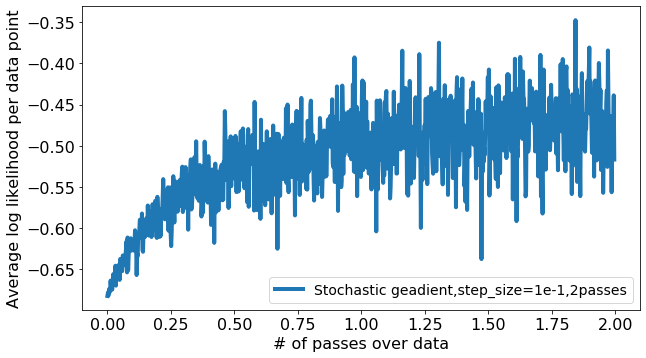

In [58]:
make_plot(log_likelihood_all,len(feature_matrix_train),100,label='Stochastic geadient,step_size=1e-1,2passes')

In [64]:
_,log_likelihood_all = logistic_regression_SG(feature_matrix_train,sentiment_train,np.zeros(194),1e-1,100,int(len(feature_matrix_train)/100*200))

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

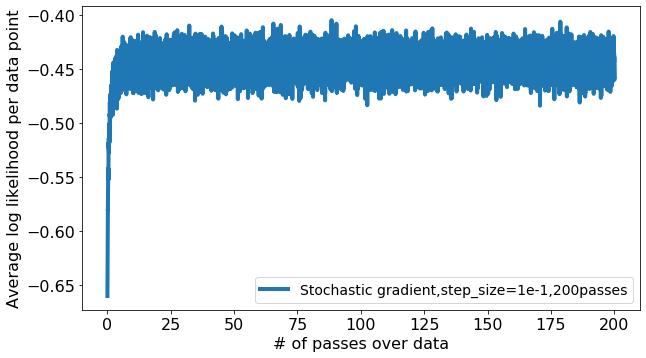

In [65]:
make_plot(log_likelihood_all,len(feature_matrix_train),100,label='Stochastic gradient,step_size=1e-1,200passes',smoothing_window=30)

In [72]:
_,log_likelihood_all = logistic_regression_SG(feature_matrix_train,sentiment_train,np.zeros(194),5e-1,len(feature_matrix_train),200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

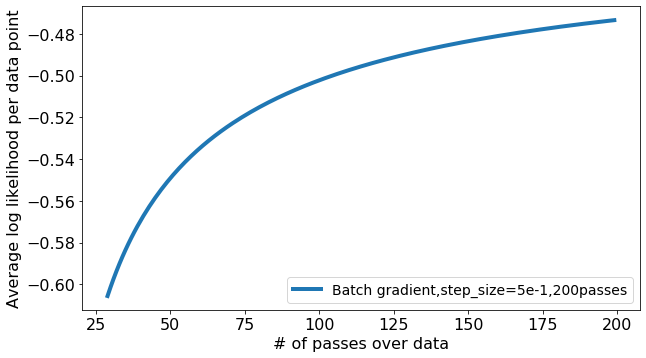

In [73]:
make_plot(log_likelihood_all,len(feature_matrix_train),len(feature_matrix_train),label='Batch gradient,step_size=5e-1,200passes',smoothing_window=30)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

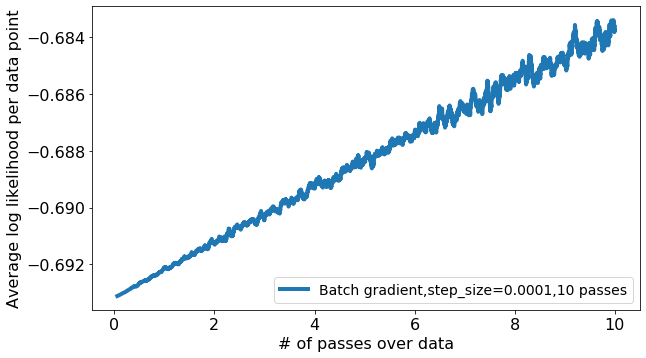

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69303759
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69299241
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69303389
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69292442
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69299113
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69298668
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69278828
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69294460
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69288708
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69295651
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69280480
Iteration   11: Average log likelihood (of data points  [01100:01

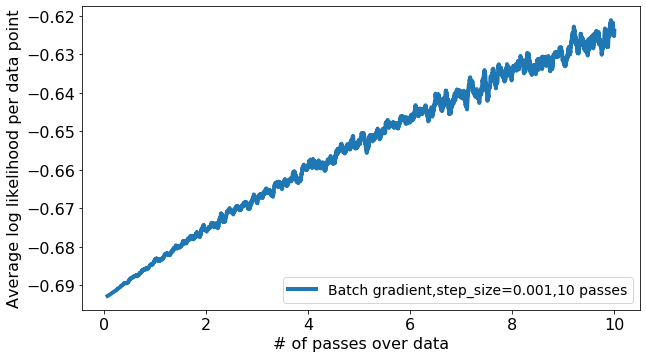

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69205420
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69160695
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69201686
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69095428
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69159348
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69154386
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.68964000
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69112685
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69056997
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69124730
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.68980179
Iteration   11: Average log likelihood (of data points  [01100:01

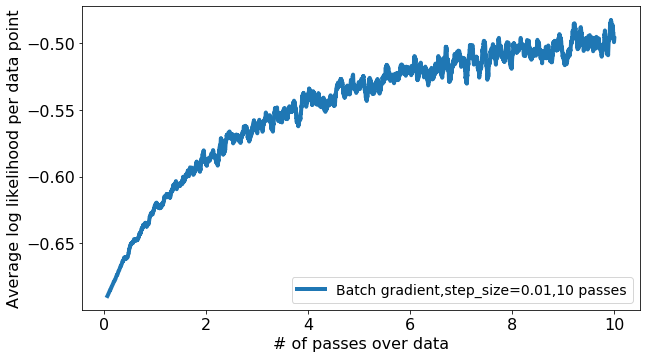

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

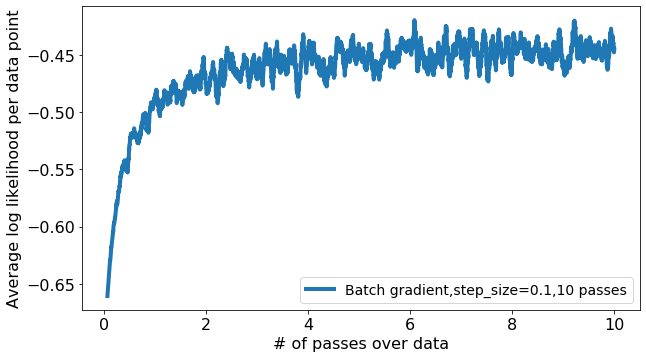

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.61201447
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.58843678
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.59771677
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.58770466
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.56939710
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.57554451
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.54068090
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.55212916
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.55311029
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.57672007
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.55455807
Iteration   11: Average log likelihood (of data points  [01100:01

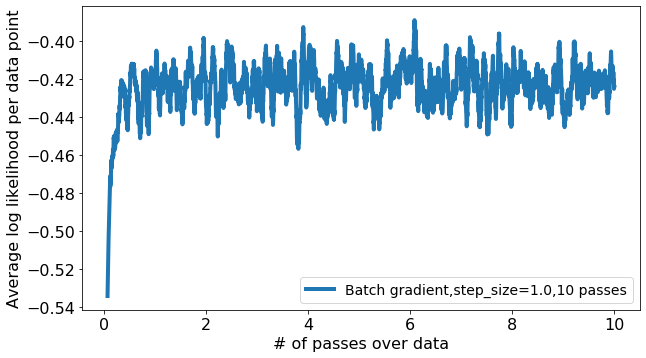

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.51319004
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -2.20035379
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -3.34199720
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -3.06285156
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -2.80822162
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -2.99629286
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -2.71489944
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -3.61713200
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -1.19526584
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.75357081
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.71310829
Iteration   11: Average log likelihood (of data points  [01100:01

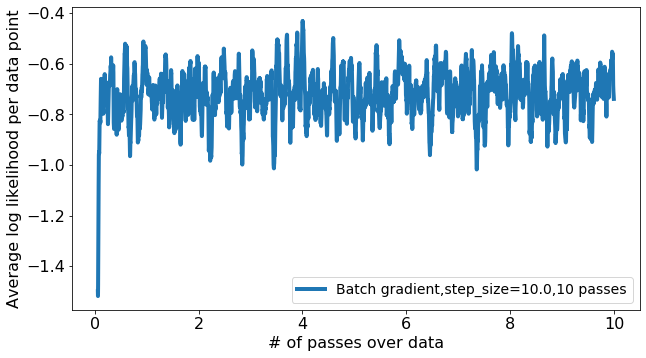

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -2.44471310
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -36.66862050
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -25.49870239
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -40.14565040
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -27.03748522
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -32.62294582
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -25.88017915
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -37.30720216
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -10.87360529
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -6.60878996
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -7.15375088
Iteration   11: Average log likelihood (of data points  [

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """



Iteration  300: Average log likelihood (of data points  [30000:30100]) = -5.77153013
Iteration  400: Average log likelihood (of data points  [40000:40100]) = -4.59158191

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



Iteration  500: Average log likelihood (of data points  [02300:02400]) = -11.55143232
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -7.84116101
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -9.04283314
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -4.69671208
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -4.28524797
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -4.54798564
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -18.25204800
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -1.83420591
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -23.70968569
Iteration 4777: Average log likelihood (of data points  [00700:00800]) = -3.86312301


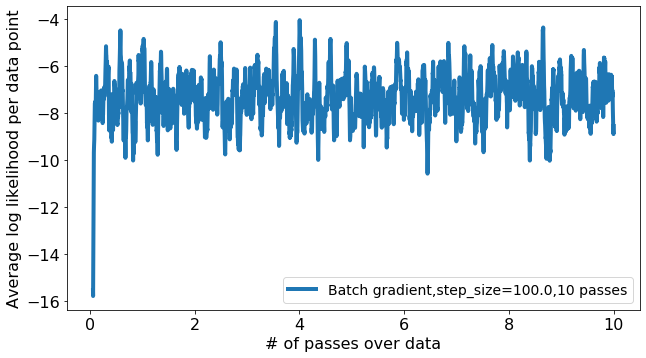

In [70]:
for step_size in [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    _,log_likelihood_all = logistic_regression_SG(feature_matrix_train,sentiment_train,np.zeros(194),step_size,100,int(len(feature_matrix_train)/100*10))
    make_plot(log_likelihood_all,len(feature_matrix_train),100,label=f'Batch gradient,step_size={step_size},10 passes',smoothing_window=30)
    plt.show()

### Best step size as per the above plots is 1, worst step size is 100